In [8]:
###SASSIE Castaway CTD DATA USE AND VISUALIZATION##

#SOURCE: https://github.com/NASA-SASSIE/data-vis/
#REFERENCE: (input doi for the running narrative here)
#CREATOR NAME: Elizabeth Westbrook
#CREATOR EMAIL: westbrooke@uncw.edu


import numpy as np
import xarray as xr
xr.set_options(display_max_rows = 100,display_width = 200)
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests

##########ENTER YOUR EARTHDATA USERNAME AND PASSWORD#############
username = 'Enter your Earth Data username here'
password = 'Enter your Earth Data password here'
earthdata = requests.auth.HTTPBasicAuth(username, password)

############ CHANGE LOCAL DIRECTORIES FOR YOUR DEVICE ############## 
 
##LOCAL DIRECTORY TO Castaway CTD DATA
dir_in = 'Enter local directory where you would like SASSIE data to be saved' #change
##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir =  'Enter local directory where you would like ice data to be saved' #change 
##LOCAL DIRECTORY TO SHIP TRACK DATA
ship_dir =  'Enter local directory where you would like SASSIE shiptrack data to be saved'  #change
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = 'Enter local directory where you would like figures to be saved' #change

In [1]:
############ DO NOT CHANGE THIS BLOCK ####################

##SASSIE DATA DIR
if not os.path.exists(dir_in):
    os.makedirs(dir_in)

##DOWNLOAD DATA FROM PO.DAAC
    filename = 'SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc'
    if os.path.isfile(dir_in+filename)==False:
        url = requests.get('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SASSIE_L2_SHIPBOARD_CASTAWAY_CTD_V1/'+filename, auth=earthdata)
        with open(dir_in+filename, 'wb') as f:
            f.write(url.content)
            print('Saving Input File: '+dir_in+filename)
    else:
        print('File already in local directory')

#ICE DIR
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)
    
##SHIP DATA DIR
if not os.path.exists(ship_dir):
    os.makedirs(ship_dir)
    url = requests.get('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SASSIE_L2_SHIPBOARD_TSG_V1/SASSIE_Fall_2022_Shipboard_TSG.nc',auth=earthdata)
    with open(ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc', 'wb') as f:
        f.write(url.content) 
    print('Saving Input File: ' +ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc')
else: 
    print('Ship Track file already in local directory')
                  
    
#FIGURE DIR
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)

################# DO NOT CHANGE THIS BLOCK ###############

Saving Input File: /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/castaway_CTD/SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc
Ship Track file already in local directory


In [2]:
#PLAY START AND END DATES (for use in functions as possible start and end dates) 
play1_start = datetime(2022,9,8,8) 
play1_end = datetime(2022,9,13)
play2_start = datetime(2022,9,14)
play2_end = datetime(2022,9,16)
play3_start = datetime(2022,9,16)
play3_end = datetime(2022,9,18)
play4_start = datetime(2022,9,19)
play4_end  = datetime(2022,9,23)
play5_start = datetime(2022,9,25)
play5_end = datetime(2022,9,29)

play_start_dates = [play1_start,play2_start,play3_start,play4_start,play5_start,play1_start]
play_end_dates = [play1_end,play2_end,play3_end,play4_end,play5_end,play5_end]

In [4]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
##UNCOMMENT PRINT STATEMENTS TO SEE INFORMATION##

file = (dir_in + 'SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc')
#SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
ds = xr.open_dataset(file)
#print(ds)

#SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
variable_info = ds.salinity
#print(variable_info)

<xarray.DataArray 'salinity' (depth: 311, time: 250)>
[77750 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2022-09-09T15:22:59.999998208 ... 2022-0...
  * depth      (depth) float64 1.0 1.296 1.591 1.887 ... 91.76 92.06 92.35 92.65
    longitude  (time) float64 ...
    latitude   (time) float64 ...
Attributes:
    units:                  1
    standard_name:          sea_water_practical_salinity
    long_name:              sea_water_practical_salinity
    coverage_content_type:  physicalMeasurement
    valid_min:              0.0
    valid_max:              42.0
    comment:                Salinity measured from Castaway instrument


In [5]:
#DEFINES COLORMAPS AND LABELS OF EACH VARIABLE IN THIS DATA SET
def define_variable_attributes(var):
    if var =='salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var =='temperature':
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    if var == 'pressure':
        colormap = 'jet'
        var_label = 'Pressure (dbar)'
    if var == 'density':
        colormap = 'winter'
        var_label = 'Density (kg m-3)'
    if var == 'latitude':
        colormap = 'jet'
        var_label = 'Latitude ($^{\circ}$N)'
    if var == 'longitude':
        colormap = 'jet'
        var_label = 'Longitude ($^{\circ}$E)'
    if var == 'time':
        colormap = 'jet'
        var_label = 'Date'
    return colormap,var_label

In [6]:
#PLOT THE LOCATION OF THE CASTAWAY CTD CASTS ON THE SHIP TRACK 
def map_cast_location(ship_track=True, bathymetry_data=True):
 
    ##CREATE A MAP WITH LAND AND CITY MARKERS  
    latmin = 70
    latmax =74
    lonmin=-157
    lonmax=-144
    
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) 
    ax.set_title('Castaway CTD Deployment Locations',fontsize=22,pad=1) 
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
    
   ##OPTIONAL MAP ADD-ONs
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc')
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
    
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    #LOAD CASTAWAY CTD DATA
    cCTD_time = np.squeeze(ds['time'])
    cCTD_lat = np.squeeze(ds['latitude'])
    cCTD_lon = np.squeeze(ds['longitude'])
        
    #APPLY cCTD TIME AND LOCATION DATA
    casts = ax.scatter(cCTD_lon,cCTD_lat,s = 10,
                       c = cCTD_time,cmap = 'jet',
                       transform=cartopy.crs.PlateCarree(),zorder=2,
                      vmin=min(cCTD_time.values), vmax=max(cCTD_time.values))
                        
    cbar = fig.colorbar(casts, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    cbar_tick_array=(np.linspace(ds['time'].values[0].astype('int64'),ds['time'].values[-1].astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    
    plt.legend(loc=2)

    
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'deployment_map/'):
        os.makedirs(fig_dir+'deployment_map/')
    
    print('Saving Output Image:  '+fig_dir+'deployment_map/cCTD_deployment_map.png')
    plt.savefig(fig_dir+'deployment_map/cCTD_deployment_map.png',dpi='figure',format='png',bbox_inches='tight')
    
    


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/deployment_map/cCTD_deployment_map.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


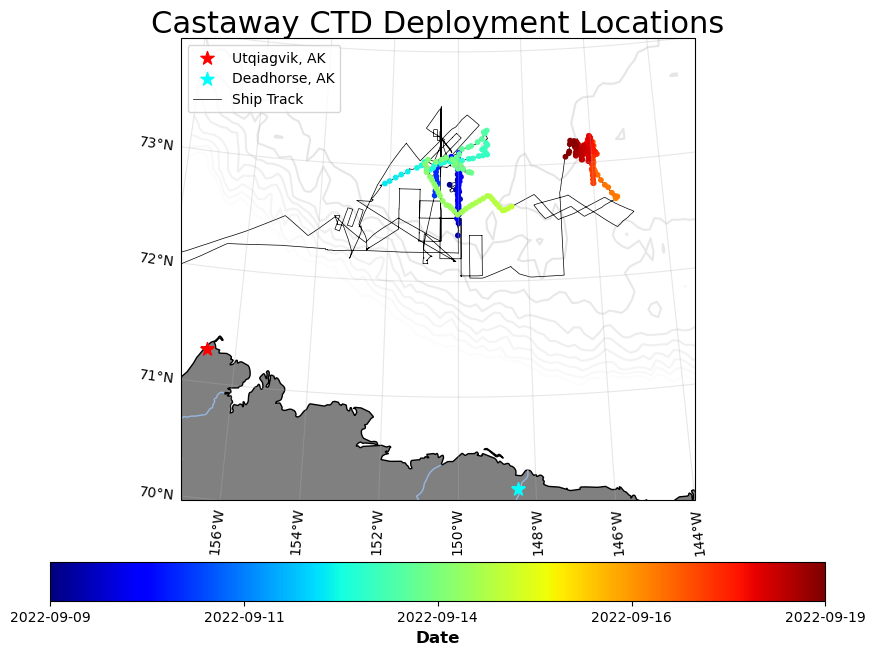

In [7]:
map_cast_location()

In [53]:
##USE TO PLOT THE PROFILES TAKEN WITHIN A DATE RANGE 
def cCTD_profiles(start_date,end_date,var,ship_track=True):
    try: 
        #LOAD CASTAWAY CTD DATA
        selected_casts = ds.sel(time=slice(start_date,end_date))
        CTD_lat = selected_casts['latitude']
        CTD_lon = selected_casts['longitude']
        CTD_depth = selected_casts['depth']
        CTD_var = selected_casts[var]

        [lat,depth] = np.meshgrid(CTD_lat,CTD_depth)
        [lon,depth] = np.meshgrid(CTD_lon,CTD_depth)
        ##CREATE 3D PLOT 
        colormap,var_label = define_variable_attributes(var)

        #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
        latmin = min(CTD_lat.values)
        latmax = max(CTD_lat.values)
        lonmin = min(CTD_lon.values)
        lonmax = max(CTD_lon.values)
        pmin = min(CTD_depth.values)
        pmax = max(CTD_depth.values)+0.5


        fig = plt.figure(figsize=(10,8))
        ax = plt.axes(projection='3d',computed_zorder=False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False    

        ax.set_title('Castaway CTD'+' '+var_label+' '+'Readings from'+' '+str(start_date.year)+'/'+str(start_date.month).zfill(2)+'/'+str(start_date.day).zfill(2)+' '+str(start_date.hour).zfill(2)+':'+str(start_date.minute).zfill(2)+' to '+str(end_date.year)+'/'+str(end_date.month).zfill(2)+'/'+str(end_date.day).zfill(2)+' '+str(end_date.hour).zfill(2)+':'+str(end_date.minute).zfill(2),fontsize=15,pad=None)

        ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(pmin,pmax);
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        xticks = list(np.linspace(lonmin,lonmax,4))
        ax.set_xticks(np.around(xticks,2))
        yticks = list(np.linspace(latmin,latmax,4))
        ax.set_yticks(np.around(yticks,2))
        zticks = list(np.linspace(pmin,pmax,4))
        ax.set_zticks(np.around(zticks,2))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_zlabel('Depth (m)')
        ax.view_init(210,60)

        if ship_track==True:
            #ADD SHIP TRACK DATA
            ds_ship_all = xr.open_dataset(ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc')
            ds_ship = ds.sel(time=slice(start_date,end_date))
            ship_time = np.squeeze(ds_ship['time'])
            ship_lat = np.squeeze(ds_ship['latitude'])
            ship_lon = np.squeeze(ds_ship['longitude'])
            track = ax.plot(ship_lon, 
                         ship_lat,
                         c='black',label = 'Ship Track',zorder=1)
        ##APPLY CTD DATA   
        a = ax.scatter(lon,lat,depth,c=(CTD_var.values),cmap = colormap,s=2,zorder=1)    
        fig.colorbar(a,label = var_label)

        ## SAVE THE FIGURE
        if not os.path.exists(fig_dir+var+'/'):
            os.makedirs(fig_dir+var+'/')

        print('Saving Output Image:  '+fig_dir+var+'/'+'cCTD'+var+str(start_date.year)+str(start_date.month).zfill(2)+str(start_date.day).zfill(2)+str(start_date.hour).zfill(2)+str(start_date.minute).zfill(2)+'_'+str(end_date.year)+str(end_date.month).zfill(2)+str(end_date.day).zfill(2)+str(end_date.hour).zfill(2)+str(end_date.minute).zfill(2)+'.png')
        plt.savefig(fig_dir+var+'/'+'cCTD'+var+str(start_date.year)+str(start_date.month).zfill(2)+str(start_date.day).zfill(2)+str(start_date.hour).zfill(2)+str(start_date.minute).zfill(2)+'_'+str(end_date.year)+str(end_date.month).zfill(2)+str(end_date.day).zfill(2)+str(end_date.hour).zfill(2)+str(end_date.minute).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')
    except: 
        print('There are no Castaway CTD profiles from ' + str(start_date.year)+'/'+str(start_date.month).zfill(2)+'/'+str(start_date.day).zfill(2)+' '+str(start_date.hour).zfill(2)+':'+str(start_date.minute).zfill(2)+' to '+str(end_date.year)+'/'+str(end_date.month).zfill(2)+'/'+str(end_date.day).zfill(2)+' '+str(end_date.hour).zfill(2)+':'+str(end_date.minute).zfill(2))
              
              
              

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/temperature/cCTDtemperature202209140000_202209160000.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/salinity/cCTDsalinity202209140000_202209160000.png


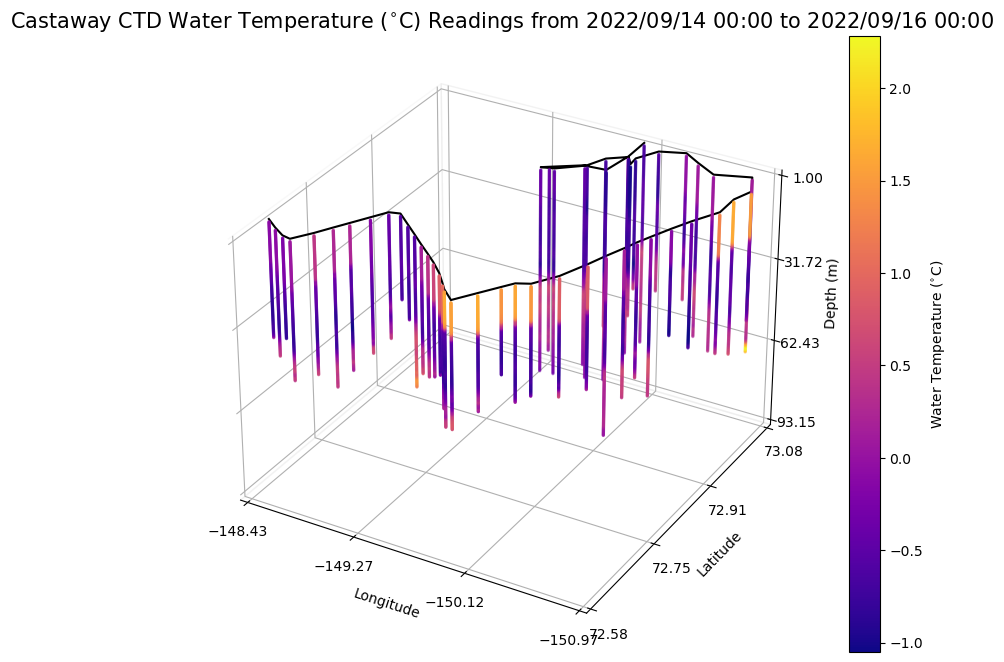

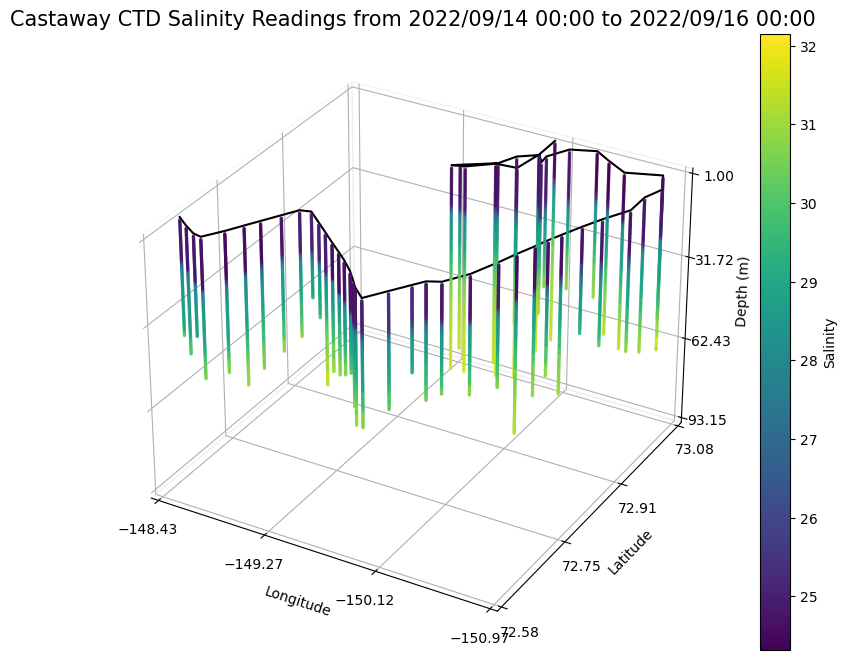

In [54]:
cCTD_profiles(play2_start,play2_end,'temperature')
cCTD_profiles(play2_start,play2_end,'salinity')

In [55]:
##MAKES A 2D PLOT OF THE CTD VARIABLES ON TIME-DEPTH AXIS (NO INTERPOLATION OF LAT/LON)
def plot_cCTD_2D(start_time,end_time,var,var_min,var_max):
   
    ##PULL OUT THE DATA WITHIN THE START AND END TIME RANGE
    ds_limited = ds.sel(time=slice(start_time,end_time))
    cCTD_time = ds_limited['time'].values
    cCTD_depth = ds_limited['depth'].values
    cCTD_var = ds_limited[var].values
    
    [time,depth] = np.meshgrid(cCTD_time,cCTD_depth)
    
    ##SET UP THE 2D PLOT 
    colormap,var_label = define_variable_attributes(var)

    dmin = min(cCTD_depth)
    dmax = max(cCTD_depth)
    tmin = min(cCTD_time)
    tmax = max(cCTD_time)
                  
    fig = plt.figure(figsize=(10,4))
    
    plt.title('Castaway CTD'+' '+var_label+' '+'Readings \nfrom '+str(start_time.year)+'/'+str(start_time.month).zfill(2)+'/'+str(start_time.day).zfill(2)+' to '+str(end_time.year)+'/'+str(end_time.month).zfill(2)+'/'+str(end_time.day).zfill(2),fontsize=15,pad=None)

    plt.xlim(tmin, tmax); plt.ylim(dmin,100);
    total_timedelta = tmax-tmin
    third_of_timedelta = total_timedelta/3
    plt.xticks([tmin,tmin+third_of_timedelta, tmin+ 2*third_of_timedelta, tmax])
    ytick = list(np.arange(0,100,15))
    plt.yticks(np.around(ytick,2))
    plt.xlabel('Date',fontsize=16)
    plt.ylabel('Depth(m)',fontsize=16)
    plt.gca().invert_yaxis()
        
    ##APPLY THE CTD DATA
    ax = plt.scatter(time,depth,s=1,c=cCTD_var,cmap=colormap,vmin = var_min,vmax=var_max)
    fig.colorbar(ax).set_label(label = var_label,size=15,weight='bold')

    ##SAVE THE FIGURE:
    if not os.path.exists(fig_dir+var+'/2d/'):
        os.makedirs(fig_dir+var+'/2d/')
    
    print('Saving Output Image:  '+fig_dir+var+'/2d/'+'cCTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png')
    plt.savefig(fig_dir+var+'/2d/'+'cCTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/temperature/2d/cCTD_temperature_202209080800_202209290000.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/salinity/2d/cCTD_salinity_202209080800_202209290000.png


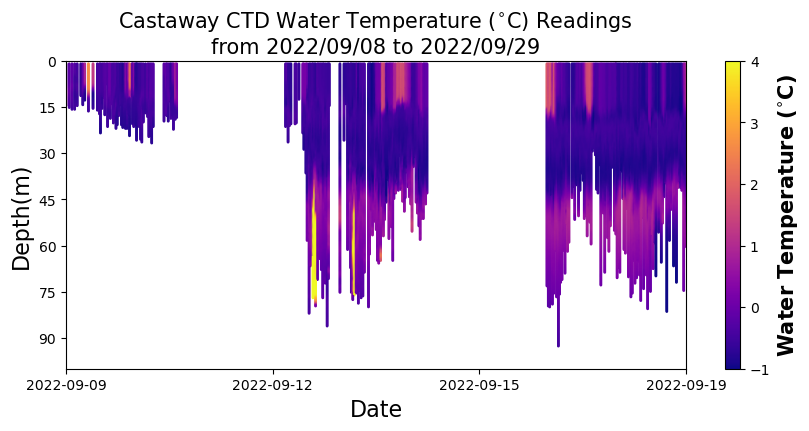

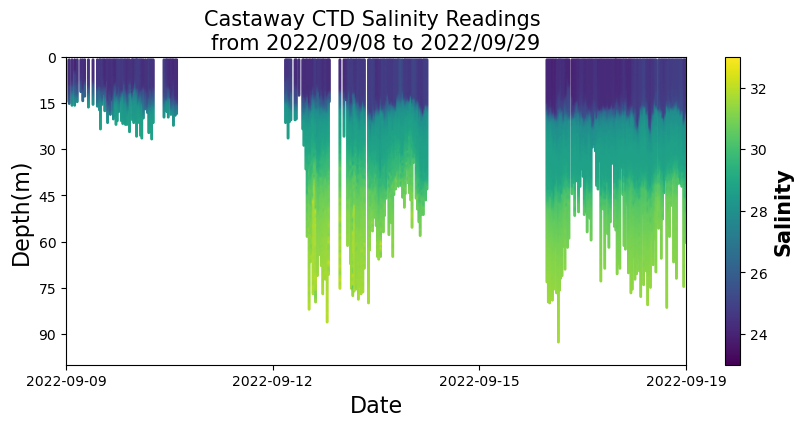

In [56]:
plot_cCTD_2D(play1_start,play5_end,'temperature',-1,4)
plot_cCTD_2D(play1_start,play5_end,'salinity',23,33)


In [57]:
##USE TO PLOT AN INDIVIDUAL CAST BY CAST NUMBER (SEPERATE AXIS)
def plot_cCTD_cast_profile_by_index_1(cast_number):
    
    #LOAD cCTD DATA 
    cCTD_sal = np.squeeze(ds['salinity'].values[:,cast_number])
    cCTD_temp = np.squeeze(ds['temperature'].values[:,cast_number])
    cCTD_dens = np.squeeze(ds['density'].values[:,cast_number])
    cCTD_depth = np.squeeze(ds['depth'].values)
    cCTD_time = np.squeeze(ds['time'].values[cast_number]).astype('int64')
    
    ## PLOT THE DATA
    fig,axs = plt.subplots(1,3,sharey=True)
    axs[0].plot(cCTD_temp,cCTD_depth,linewidth=0.4,c='black')
    axs[0].invert_yaxis()
    #axs[0].set_title('Water Temperature ($^{\circ}$C)')
    axs[0].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0].set_ylabel('Depth (m)')
    axs[1].plot(cCTD_sal,cCTD_depth,linewidth=0.4,c='black')
    #axs[1].set_title('Salinity')
    axs[1].set_xlabel('Salinity')
    axs[2].plot(cCTD_dens,cCTD_depth,linewidth=0.4,c='black')
    axs[2].set_xlabel('Density (kg m-3)')
    fig.suptitle('cCTD Profiles from Cast '+str(cast_number)+' on '+str(pd.to_datetime(cCTD_time).year).zfill(2)+'/'+str(pd.to_datetime(cCTD_time).month).zfill(2)+'/'+str(pd.to_datetime(cCTD_time).day).zfill(2)+' at '+str(pd.to_datetime(cCTD_time).hour).zfill(2)+':'+str(pd.to_datetime(cCTD_time).minute).zfill(2)+':'+str(pd.to_datetime(cCTD_time).second).zfill(2))
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+'profiles/'):
        os.makedirs(fig_dir+'profiles/')
    print('Saving Output Image:  '+fig_dir+'profiles/'+'cCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(cCTD_time).year)+str(pd.to_datetime(cCTD_time).month).zfill(2)+str(pd.to_datetime(cCTD_time).day).zfill(2)+str(pd.to_datetime(cCTD_time).hour).zfill(2)+str(pd.to_datetime(cCTD_time).minute).zfill(2)+str(pd.to_datetime(cCTD_time).second).zfill(2)+'.png')
    plt.savefig(fig_dir+'profiles/'+'cCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(cCTD_time).year)+str(pd.to_datetime(cCTD_time).month).zfill(2)+str(pd.to_datetime(cCTD_time).day).zfill(2)+str(pd.to_datetime(cCTD_time).hour).zfill(2)+str(pd.to_datetime(cCTD_time).minute).zfill(2)+str(pd.to_datetime(cCTD_time).second).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/profiles/cCTD_profile100_20220914013000.png


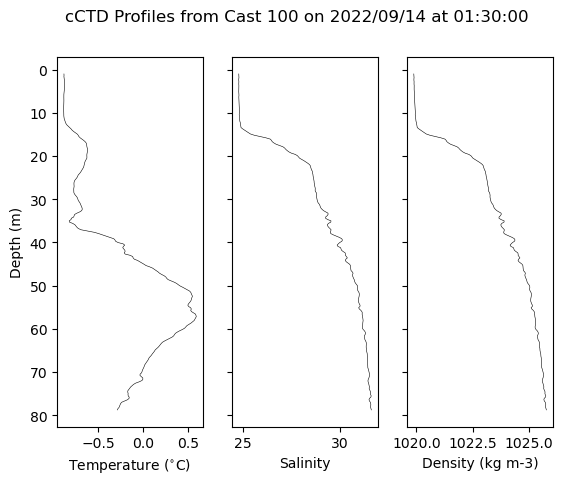

In [58]:
plot_cCTD_cast_profile_by_index_1(100)

In [59]:
##USE TO PLOT AN INDIVIDUAL CAST BY CAST NUMBER (SAME AXIS)
def plot_cCTD_cast_profile_by_index_2(cast_number):
    
    #LOAD cCTD DATA 
    cCTD_sal = np.squeeze(ds['salinity'].values[:,cast_number])
    cCTD_temp = np.squeeze(ds['temperature'].values[:,cast_number])
    cCTD_dens = np.squeeze(ds['density'].values[:,cast_number])
    cCTD_depth = np.squeeze(ds['depth'].values)
    cCTD_time = np.squeeze(ds['time'].values[cast_number]).astype('int64')
    cCTD_lat = np.squeeze(ds['latitude'].values[cast_number])
    cCTD_lon = np.squeeze(ds['longitude'].values[cast_number])
    
    ## PLOT THE DATA
    fig,ax1 = plt.subplots()
    ax2 = ax1.twiny()
    ax1.plot(cCTD_temp,cCTD_depth,linewidth=0.4,c='blue')
    ax1.set_xlabel('Temperature ($^{\circ}$C)',color = 'blue')
    ax1.set_ylabel('Depth (m)')
    ytick_array = np.arange(0,100,20)
    ax1.set_ylim(0,100)
    ax1.set_yticks(ytick_array)
    ax1.invert_yaxis()
    ax2.plot(cCTD_sal,cCTD_depth,linewidth=0.4,c='red')
    ax2.set_xlabel('Salinity',color ='red')    
    fig.suptitle('cCTD Profiles from Cast '+str(cast_number)+' at ' +str(np.around(cCTD_lat,decimals=2))+'$^{\circ}$N, '+str(np.around(cCTD_lon,decimals=2))+'$^{\circ}$E \n on '+str(pd.to_datetime(cCTD_time).year).zfill(2)+'/'+str(pd.to_datetime(cCTD_time).month).zfill(2)+'/'+str(pd.to_datetime(cCTD_time).day).zfill(2)+' at '+str(pd.to_datetime(cCTD_time).hour).zfill(2)+':'+str(pd.to_datetime(cCTD_time).minute).zfill(2)+':'+str(pd.to_datetime(cCTD_time).second).zfill(2),y=1.05)
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+'profiles/'):
        os.makedirs(fig_dir+'profiles/')
    print('Saving Output Image:  '+fig_dir+'profiles/'+'cCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(cCTD_time).year)+str(pd.to_datetime(cCTD_time).month).zfill(2)+str(pd.to_datetime(cCTD_time).day).zfill(2)+str(pd.to_datetime(cCTD_time).hour).zfill(2)+str(pd.to_datetime(cCTD_time).minute).zfill(2)+str(pd.to_datetime(cCTD_time).second).zfill(2)+'.png')
    plt.savefig(fig_dir+'profiles/'+'cCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(cCTD_time).year)+str(pd.to_datetime(cCTD_time).month).zfill(2)+str(pd.to_datetime(cCTD_time).day).zfill(2)+str(pd.to_datetime(cCTD_time).hour).zfill(2)+str(pd.to_datetime(cCTD_time).minute).zfill(2)+str(pd.to_datetime(cCTD_time).second).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/profiles/cCTD_profile100_20220914013000.png


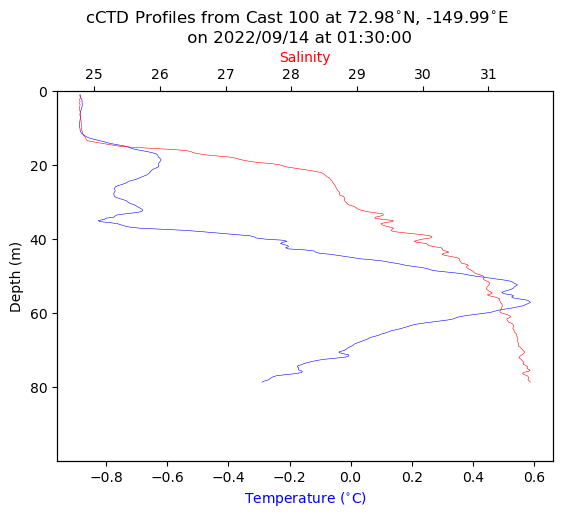

In [60]:
plot_cCTD_cast_profile_by_index_2(100)

In [61]:
def plot_T_S_diagram(start_time,end_time,var):
    
    ##PULL OUT THE DATA WITHIN THE START AND END TIME RANGE
    ds_limited = ds.sel(time=slice(start_time,end_time))
    cCTD_temp = ds_limited['temperature'].values
    cCTD_depth = ds_limited['depth'].values
    cCTD_sal = ds_limited['salinity'].values
    cCTD_var = ds_limited[var].values
    cCTD_time = ds_limited['time'].values   
    if var !='pressure':
        [depth,var_values] = np.meshgrid(cCTD_depth,cCTD_var)
    else: 
        var_values = cCTD_var
                
    ##SET UP THE 2D PLOT
    colormap,var_label = define_variable_attributes(var)

    fig = plt.figure(figsize=(10,4))
    plt.title('Temperature-Salinity Diagram of Castaway CTD Data')
    
    if var=='pressure':
        ax = plt.scatter(cCTD_sal,cCTD_temp,s=1,c=var_values,cmap=colormap,vmin=0,vmax=100)
    else:
        ax = plt.scatter(cCTD_sal,cCTD_temp,s=1,c=var_values,cmap=colormap,vmin=cCTD_var.min(),vmax=cCTD_var.max())
    plt.xlim((23,32))
    plt.xlabel('Salinity',fontsize=16)
    plt.ylabel('Temperature ($^{\circ}$C)',fontsize=16)
    
    ##SET UP COLORBAR
    if (var == 'time'): 
        cbar = fig.colorbar(ax, orientation="vertical", pad=0.1)
        cbar.set_label(label=var_label,size='large',weight='bold')
        cbar_tick_array=(np.linspace(ds[var].values[0].astype('int64'),ds[var].values[-1].astype('int64'),5))
        cbar.set_ticks(cbar_tick_array)
        cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    else:
        fig.colorbar(ax).set_label(label = var_label,size=15,weight='bold')

    ##SAVE THE FIGURE
    if not os.path.exists(fig_dir+'t_s/'):
        os.makedirs(fig_dir+'t_s/')
    print('Saving Output Image:  '+fig_dir+'t_s/T_S_Diagram_'+var+'.png')
    plt.savefig(fig_dir+'t_s/T_S_Diagram_'+var+'.png',dpi='figure',format='png',bbox_inches='tight')


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/t_s/T_S_Diagram_pressure.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/castaway_CTD/t_s/T_S_Diagram_latitude.png


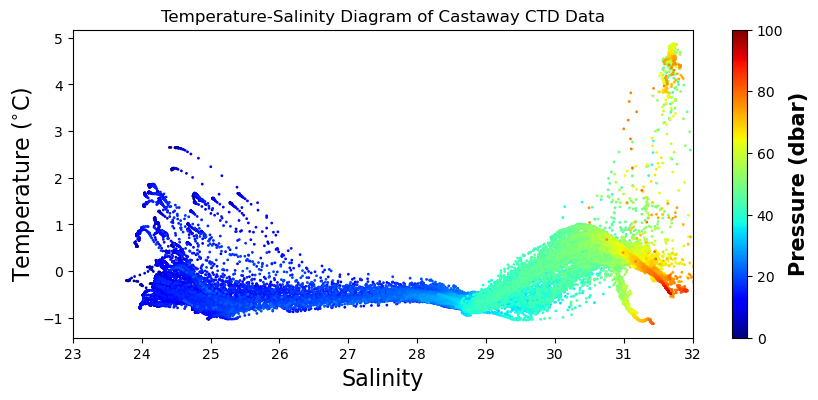

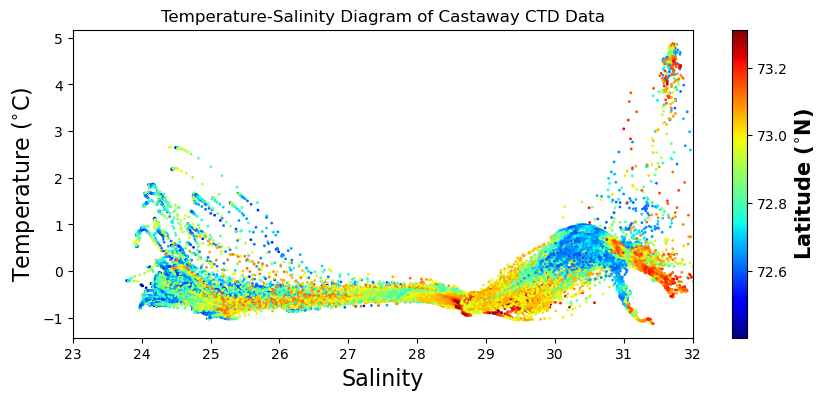

In [62]:
plot_T_S_diagram(play1_start,play5_end,'pressure')
plot_T_S_diagram(play1_start,play5_end,'latitude')